# Klasteryzacja

## Konfiguracja

Użyjemy standardowych bibliotek oraz dodatkowo:
- Plotly - do wizualizacji
- UMAP - redukcja wymiarowości

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn


sklearn.set_config(transform_output="pandas")

## Analiza muzyki ze Spotify

Spotify w swoim API oferuje automatyczną [ekstrakcję cech z piosenek](https://developer.spotify.com/documentation/web-api/reference/get-audio-features), których można następnie użyć do wielu ciekawych analiz, jak np. [tutaj](https://rpubs.com/PeterDola/SpotifyTracks) lub [tutaj](https://rstudio-pubs-static.s3.amazonaws.com/604869_8399a2cf0e4a419da6272452c3d6a6d3.html). Datasetów jest wiele, z czego jednym z największych [jest dostępny tutaj na Kaggle](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) i zawiera ponad 600 tysięcy piosenek.

Cechy zwracane przez API to m. in. akustyczność, taneczność, energia, głośność czy długość piosenki. Pełna lista cech jest dostępna [w dokumentacji](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). Są to bardzo dobre cechy do uczenia maszynowego - niewielka wymiarowość i tylko numeryczne. Wadą jest pewna dość mocna korelacja w niektórych podgatunkach muzycznych, ale akurat to w przypadku klasteryzacji takich danych jest całkiem ok, i może prowadzić do sensownych wniosków.

Spotify definiuje i wykorzystuje ponad 125 gatunków muzycznych, które na dodatek są dość dyskusyjne i płynne. Przykładowo, według różnych klasyfikacji Powerwolf, Ensiferum i Alestorm mogą wylądować w tym samym worku, pomimo zdecydowanie różnej muzyki. Klasteryzacja pozwala tworzyć "płynne" tagi, klasyfikując muzykę w dużo bardziej zniuansowany sposób.

**Uwaga:** zgodnie z licencją API danych nie można używać do treningu modeli ML. Oczywiście tego typu licencje nie dotyczą użytku prywatnego ani zastosowań naukowych, co wynika z ogólnych przepisów. Należy jednak pamiętać, że takich modeli nie wolno w żaden sposób publikować ani wykorzystywać komercyjnie.

**Zadanie 1 (2.5 punktu)**

1. Ściągnij pliki `artists.csv` oraz `tracks.csv` z Kaggle'a.
2. Załaduj pliki `artists.parquet` i `tracks.parquet` do zmiennych `df_artists` i `df_tracks`.
3. Usuń wiersze z wartościami brakującymi z obu ramek danych.
4. Ponad 600 tysięcy piosenek to zdecydowanie za dużo, a na dodatek przeważająca większość z nich to drobni, mało znani artyści. Aby to zweryfikować, narysuj histogramy popularności artystów oraz piosenek. Użyj 100 kubełków (bins). Pamiętaj o tytułach wykresów.
5. Dokonaj filtrowania:
   - pozostaw artystów z popularnością >= 55
   - pozostaw piosenki z popularnością >= 55
   - usuń piosenki trwające powyżej 600000 ms (10 minut)
   - użyj funkcji `remove_weird_genres()`, żeby usunąć piosenki z ekstremalnie rzadkich gatunków muzycznych
   - użyj funkcji `filter_english_only()`, aby pozostawić tylko anglojęzyczne tytuły
6. Użyj podanej funkcji `extract_artist_id()` na ramce z piosenkami, która dodaje kolumnę `main_artist_id`.
7. Połącz ramki w jedną, `df_songs`, z wszystkimi informacjami:
   - użyj kolumn `main_artist_id` (ramka z piosenkami) oraz `id` (ramka z artystami)
   - przyda się `pd.merge()`
   - Pandas automatycznie dodaje sufiksy do kolumn (argument `suffixes`), żeby rozróżnić kolumny po takiej operacji JOIN
   - domyślnie są to mało znaczące `_x` i `_y`, zmień je na `_track` i `_artist`
8. Usuń duplikaty wedle kolumn `name_track` oraz `name_artist`.
9. Mamy kolumny z danymi, które identyfikują piosenki: nazwa piosenki, artysta, gatunki muzyczne. Nie są one jednak użyteczne do samej klasteryzacji. Wyodrębnij je do osobnej ramki `df_songs_info`.
```
songs_info_cols = [
    "name_track",
    "name_artist",
    "genres"
]
```
10. Stwórz nową ramkę `df_songs_features`, pozostawiając tylko kolumny z cechami do klasteryzacji:
```
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
```
11. Wypisz finalną liczbę piosenek (rozmiar zbioru).

**Uwaga:** jeżeli notebook będzie wykonywał się zbyt długo, to można ustawić wyższy próg popularności, żeby uzyskać mniejszy podzbiór najbardziej popularnych piosenek.

In [3]:
import ast
from fast_langdetect import detect as detect_language


def extract_artist_id(df_tracks: pd.DataFrame) -> pd.DataFrame:
    df_tracks["main_artist_id"] = df_tracks["id_artists"].apply(
        lambda x: ast.literal_eval(x)[0]
    )
    return df_tracks


def remove_weird_genres(df_songs: pd.DataFrame) -> pd.DataFrame:
    all_genres = []
    for song_genres in df_songs["genres"]:
        all_genres.extend(ast.literal_eval(song_genres))

    df_genres = pd.Series(all_genres).value_counts().reset_index()

    weird_genres = df_genres.loc[df_genres["count"] < 150, "index"]
    weird_genres = set(weird_genres.tolist())

    to_keep = []
    for song_genres in df_songs["genres"]:
        song_genres = set(ast.literal_eval(song_genres))
        not_all_weird = len(song_genres - weird_genres) > 0
        to_keep.append(not_all_weird)

    df_songs = df_songs[to_keep]
    return df_songs


def filter_english_only(df_songs: pd.DataFrame) -> pd.DataFrame:
    english = [
        detect_language(title[:100], low_memory=False)["lang"] == "en"
        for title in df_songs["name_track"]
    ]
    return df_songs[english]

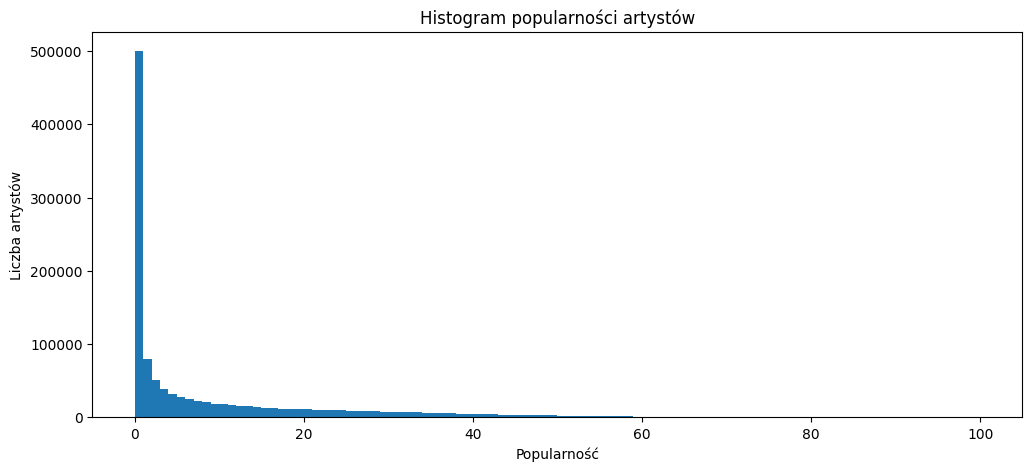

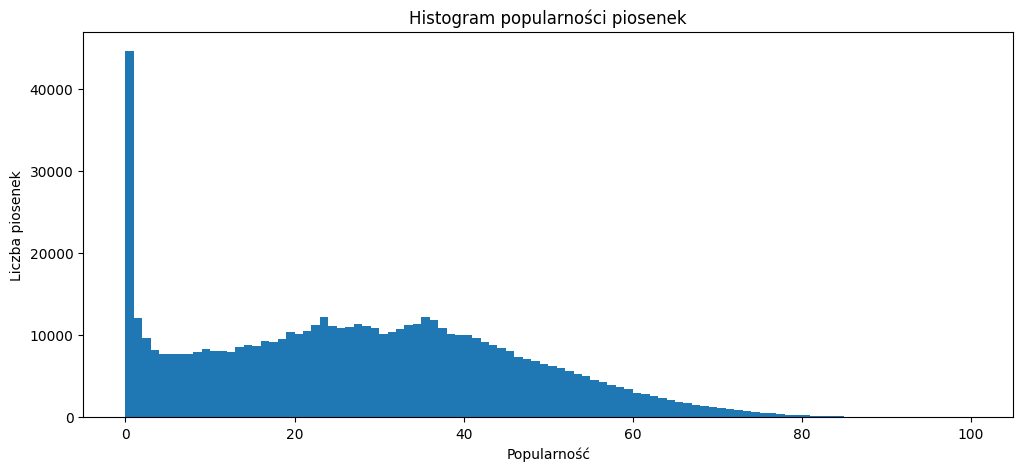

[2025-06-07 14:30:52,428][INFO] - Downloading https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin to lid.176.bin (125.2M)


  0%|          | 0.00/125M [00:00<?, ?B/s]

Liczba piosenek po przetworzeniu: 20817


In [4]:
df_artists = pd.read_csv("artists.csv")
df_tracks = pd.read_csv("tracks.csv")

df_artists.dropna(inplace=True)
df_tracks.dropna(inplace=True)

plt.figure(figsize=(12, 5))
plt.hist(df_artists["popularity"], bins=100)
plt.title("Histogram popularności artystów")
plt.xlabel("Popularność")
plt.ylabel("Liczba artystów")
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(df_tracks["popularity"], bins=100)
plt.title("Histogram popularności piosenek")
plt.xlabel("Popularność")
plt.ylabel("Liczba piosenek")
plt.show()

df_artists = df_artists[df_artists["popularity"] >= 55]
df_tracks = df_tracks[df_tracks["popularity"] >= 55]
df_tracks = df_tracks[df_tracks["duration_ms"] <= 600_000]

df_tracks = extract_artist_id(df_tracks)

df_songs = pd.merge(
    df_tracks,
    df_artists,
    left_on="main_artist_id",
    right_on="id",
    suffixes=("_track", "_artist"),
)

df_songs = df_songs.drop_duplicates(subset=["name_track", "name_artist"])

df_songs = remove_weird_genres(df_songs)
df_songs = filter_english_only(df_songs)

songs_info_cols = ["name_track", "name_artist", "genres"]
songs_features_cols = [
    "explicit",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

df_songs_info = df_songs[songs_info_cols]
df_songs_features = df_songs[songs_features_cols]

print("Liczba piosenek po przetworzeniu:", len(df_songs_features))

Mamy teraz przygotowane dane, więc można brać się za klasteryzację. Nasz zbiór jest dość duży, nawet po dokonanym ostrym filtrowaniu, więc potrzebujemy skalowalnych algorytmów klasteryzacji. Klasteryzacja hierarchiczna zdecydowanie odpada, pozostają więc k-means, DBSCAN i HDBSCAN. Co prawda hiperparametry do DBSCAN ciężko jest dobrać, ale zobaczymy, jak można to zrobić.

Zanim przejdziemy do klasteryzacji, trzeba ustandardyzować nasze dane. Po tym trzeba przeprowadzić też globalną analizę naszego zbioru, jak na przykład rozkłady cech, albo zwizualizować go z pomocą redukcji wymiaru. Jest to ważne, bo przy późniejszej analizie klastrów musimy wiedzieć, czy klastry w ogóle różnią się od ogółu naszych danych.

**Zadanie 2 (1 punkt)**

1. Dokonaj standaryzacji cech, tworząc ramkę `X`.
2. Uzupełnij kod klasy `ClusteringVisualizer`, która przyjmuje dane, numery klastrów dla poszczególnych punktów (opcjonalne), i przedstawia wykresy PCA oraz UMAP:
   - zredukuj dane do 2 wymiarów
   - pamiętaj o `random_state=0`
   - [dokumentacja UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
   - przekaż `low_memory=False` dla UMAP
   - ze względu na specyfikę implementacji, wykorzystanie `.fit_transform()` będzie zauważalnie szybsze od osobnych `.fit()` i `.transform()`
   - skomentuj:
     - czy w przypadkU PCA widać jakąś strukurę klastrów?
     - czy widać ją w przypadku UMAP?
     - czy redukcja nieliniowa dała lepsze, czy gorsze wyniki od liniowego PCA w wizualizacji?

Czemu klasa, a nie funkcja? UMAP, jak praktycznie wszystkie metody nieliniowej redukcji wymiaru, wykorzystuje graf najbliższych sąsiadów. Jeżeli obliczymy dane po redukcji raz, i zapiszemy jako atrybut, to później będziemy mogli uniknąć liczenia tego wielokrotnie. Zapisanie tych wyników zaoszczędzi nam wiele minut :)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from typing import Optional


class ClusteringVisualizer:
    def __init__(self, X: np.ndarray | pd.DataFrame):
        self.X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X

        # PCA
        self.X_pca = PCA(n_components=2, random_state=0).fit_transform(self.X_array)
        self.X_pca = self.X_pca.to_numpy()

        # UMAP
        self.X_umap = UMAP(low_memory=False, random_state=0).fit_transform(self.X_array)

    def visualize(self, labels: Optional[np.ndarray] = None):
        if labels is None:
            labels = np.ones(self.X_array.shape[0])

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].scatter(
            self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap="tab10", s=10, alpha=0.6
        )
        axes[0].set_title("PCA")

        axes[1].scatter(
            self.X_umap[:, 0],
            self.X_umap[:, 1],
            c=labels,
            cmap="tab10",
            s=10,
            alpha=0.6,
        )
        axes[1].set_title("UMAP")

        fig.suptitle("Clustering visualization")
        plt.tight_layout()
        plt.show()

/home/ernest/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ernest/podstawy-uczenia-maszynowego-24-25/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


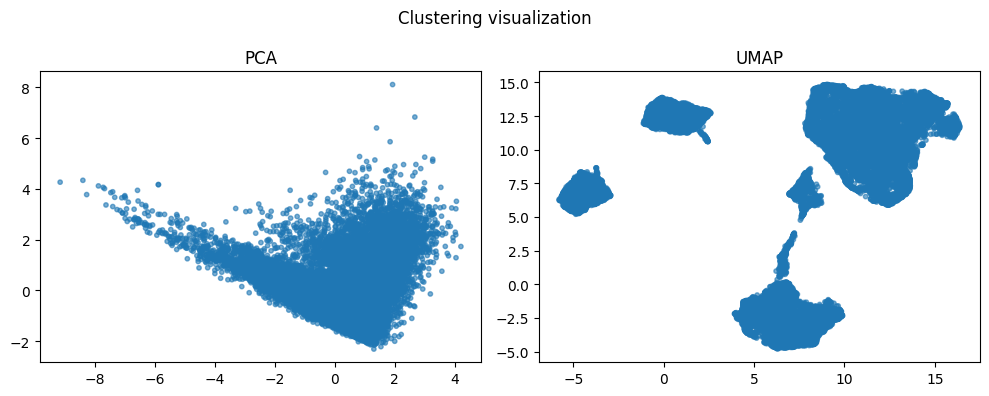

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_songs_features)

clustering_visualizer = ClusteringVisualizer(X)
clustering_visualizer.visualize()

W przypadku pca nic nie widać, jest to jakby jeden wielki klaster z dużą ilością szumu, w przypadku UMAPa wyraźnie widać klastry, mało szumu.

Nieliniowa redukcja jest w tym przypadku zdecydowanie bardziej wartościowa

Teraz przeanalizujemy nasz zbiór. Posłużą nam do tego poniżej zdefiniowane klasy `KMeansAnalzyer`, `DBSCANAnalyzer` i `HDBSCANAnalyzer`. Metoda `.analyze_clustering()` dla każdego klastra:
1. Wypisuje liczbę klastrów, oraz informację o szumie (dla DBSCAN i HDBSCAN).
2. Wypisuje wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html), jeżeli liczba klastrów to co najmniej 2. Dla DBSCAN i HDBSCAN uwzględniamy tylko punkty z klastrów, ignorując szum.
2. Rysuje wykres klastrów po redukcji z PCA oraz UMAP.
3. Tworzy [wykres radowy (radar chart)](https://plotly.com/python/radar-chart/). Pozwala on wygodnie porównać wartości średnie dla poszczególnych cech.
4. Wypisuje piosenki i artystów reprezentujące klaster:
   - dla k-means jest to 10 punktów najbliższych do centroidu
   - dla DBSCAN wybieramy heurystycznie 10 punktów najbliższych do centroidu
   - dla HDBSCAN wybieramy punkty o najwyższym prawdopodobieństwie (nie używamy exemplars, bo jest to bardzo wolne [i mało wygodne](https://github.com/scikit-learn-contrib/hdbscan/issues/304))
5. Wypisuje 10 najczęstszych gatunków muzycznych w klastrze.

Dla DBSCAN i HDBSCAN, które same wykrywają liczbę klastrów i może być ich bardzo dużo, analizowane jest tylko:
- max 10 największych klastrów
- tylko te, które mają co najmniej 100 próbek

Na początek potraktujemy cały nasz zbiór jako jeden wielki klaster dla algorytmu k-means i popatrzymy, co tam się dzieje.

In [29]:
import itertools
from abc import ABC, abstractmethod
from collections import Counter

import plotly.graph_objects as go

from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale


class ClusteringAnalyzer(ABC):
    def __init__(
        self, df_songs_info: pd.DataFrame, clustering_visualizer: ClusteringVisualizer
    ):
        self.df_songs_info = df_songs_info
        self.clustering_visualizer = clustering_visualizer

    @abstractmethod
    def analyze_clustering(self, X: pd.DataFrame, clustering) -> None:
        raise NotImplementedError()

    def _get_top_clusters_labels(self, labels: np.ndarray) -> np.ndarray:
        labels = labels[labels != -1]
        label_counts = pd.Series(labels).value_counts()
        label_counts = label_counts[label_counts >= 100]
        top_labels = label_counts.index[:10].values
        return top_labels

    def _create_radar_chart(self, X: pd.DataFrame, label: int) -> None:
        fig = go.Figure()
        vals = minmax_scale(X).mean()
        fig.add_trace(go.Scatterpolar(r=vals, theta=X.columns, fill="toself"))
        fig.update_layout(title_text=f"Cluster {label}", title_x=0.5)
        fig.update_polars(radialaxis=dict(range=[0, 1]))
        fig.show()

    def _get_central_songs(
        self, X: pd.DataFrame, cluster_songs_info: pd.DataFrame, prototype: np.ndarray
    ) -> None:
        n_neighbors = min(10, len(X))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(X.values)
        _, nn_idxs = nn.kneighbors(prototype)
        nn_idxs = nn_idxs.ravel()
        nn_songs_info = cluster_songs_info.iloc[nn_idxs]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

    def _get_cluster_top_genres(
        self,
        cluster_songs_info: pd.DataFrame,
    ) -> None:
        genres = cluster_songs_info["genres"].values
        genres = [ast.literal_eval(x) for x in genres]
        genres = Counter(itertools.chain(*genres))
        top_genres = genres.most_common(10)
        top_genres = [name for name, count in top_genres]
        print("Top 10 genres in the cluster:", top_genres)


class KMeansAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: KMeans) -> None:
        labels = clustering.labels_
        centroids = clustering.cluster_centers_

        print(f"Number of clusters: {max(labels) + 1}")

        if labels.max() >= 2:
            ch_index = calinski_harabasz_score(X, labels)
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in range(0, max(labels) + 1):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = centroids[label].reshape((1, -1))

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)


class DBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: DBSCAN) -> None:
        labels = clustering.labels_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            centroid = self._get_cluster_centroid(X_cluster)

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_central_songs(X_cluster, cluster_songs_info, centroid)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_cluster_centroid(self, X_cluster: pd.DataFrame) -> np.ndarray:
        centroid = np.mean(X_cluster.values, axis=0)
        return np.array(centroid).reshape((1, -1))


class HDBSCANAnalyzer(ClusteringAnalyzer):
    def analyze_clustering(self, X: pd.DataFrame, clustering: HDBSCAN) -> None:
        labels = clustering.labels_
        probas = clustering.probabilities_

        noise_num = (labels == -1).sum()
        noise_perc = noise_num / len(X)

        print(f"Number of clusters: {max(labels) + 1}")
        print(f"Percentage of noise points: {100 * noise_perc:.2f}%")

        if labels.max() >= 2:
            X_non_noise = X[labels != -1]
            labels_non_noise = labels[labels != -1]
            ch_index = calinski_harabasz_score(
                X_non_noise,
                labels_non_noise,
            )
            print(f"CH-index value: {ch_index:.2f}")

        self.clustering_visualizer.visualize(labels)

        for label in self._get_top_clusters_labels(labels):
            X_cluster = X[labels == label]
            cluster_songs_info = df_songs_info[labels == label]
            cluster_probas = probas[labels == label]

            print(f"Cluster {label} size: {len(X_cluster)}")
            self._create_radar_chart(X_cluster, label)
            self._get_most_probable_songs(X_cluster, cluster_songs_info, cluster_probas)
            self._get_cluster_top_genres(cluster_songs_info)

    def _get_most_probable_songs(
        self,
        X: pd.DataFrame,
        cluster_songs_info: pd.DataFrame,
        cluster_probas: np.ndarray,
    ) -> None:
        top_10_indexes = np.argpartition(cluster_probas, -10)[-10:]
        nn_songs_info = cluster_songs_info.iloc[top_10_indexes]
        nn_songs_info = nn_songs_info.drop(columns="genres")
        nn_songs_info.columns = ["Track", "Artist"]
        nn_songs_info = nn_songs_info.reset_index(drop=True)
        display(nn_songs_info)

Number of clusters: 1
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


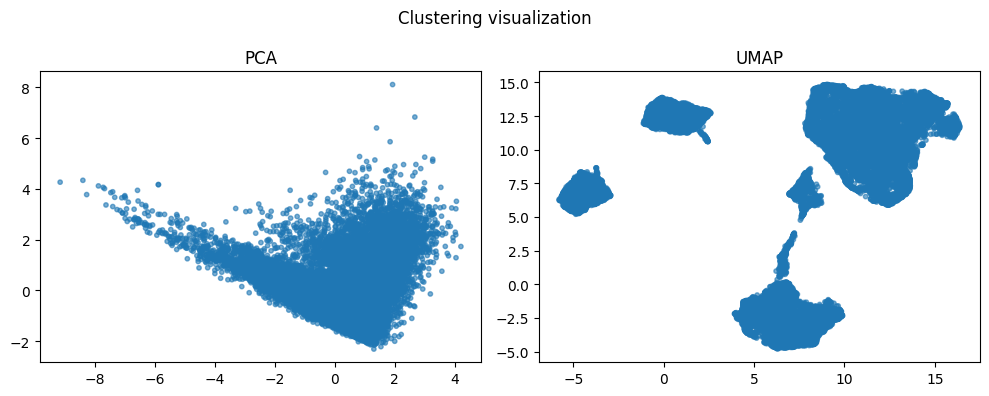

Cluster 0 size: 20817


,Track,Artist
0,"Yes Sir, I Can Boogie",Baccara
1,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
2,Just A Lover,Hayden James
3,"Odhani (From ""Made in China"")",Sachin-Jigar
4,Fake ID,Riton
5,It's All About Me,Mýa
6,Sexy Lady,MC Magic
7,Brown Skin,India.Arie
8,Drive (For Daddy Gene),Alan Jackson
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'rap', 'pop rap', 'hip hop', 'classic rock', 'mellow gold', 'soft rock']


In [30]:
from sklearn.cluster import KMeans


clustering = KMeans(n_clusters=1, n_init="auto", random_state=0)
clustering.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, clustering)

Wygląda na to, że najpopularniejsze są pop i rock, a najbardziej "typowe" piosenki też należą do takiej grupy. Ogół piosenek ma dość dużą głośność, dużą dynamikę (wysokie time signature - "how many beats are in each bar") i są pozytywne (valence - "tracks with high valence sound more positive"). Zasadniczo jest to zgodne z intuicją. Ciekawe jednak, co będzie, jak wybierzemy więcej klastrów.

**Zadanie 3 (1.5 punktu)**

1. Wytrenuj k-means dla 3 klastrów.
2. Zwizualizuj wyniki za pomocą PCA i UMAP. Jako kolor punktów (np. parametr `c` w `plt.scatter()`) przekaż numery klastrów dla punktów.
3. Dokonaj opisu i analizy wynikowych klastrów, na przykład:
   - czy reprezentują jakieś konkretne grupy muzyczne?
   - na ile "konkretne", sensowne są klastry?
   - czy jest widoczna separacja klastrów, czy różnią się od siebie?
4. Dokonaj tuningu liczby klastrów:
   - sprawdź wartości z zakresu [5, 20] - w końcu wiemy, że gatunków jest sporo, i klastrów powinno też być więcej
   - dla każdej wartości sprawdź wartość metryki [Calinski-Harabasz index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
   - przedstaw wykres liniowy (line plot) wartości metryki
   - wybierz model o najwyższej wartości metryki
   - zwizualizuj wyniki z pomocą PCA i UMAP
   - dokonaj interpretacji jego klastrów
   - skomentuj:
     - czy klastry są faktycznie lepiej interpretowalne po tuningu?
     - czy wysokość CH-index faktycznie odpowiada jakości klasteryzacji?


Number of clusters: 3
CH-index value: 3111.41
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


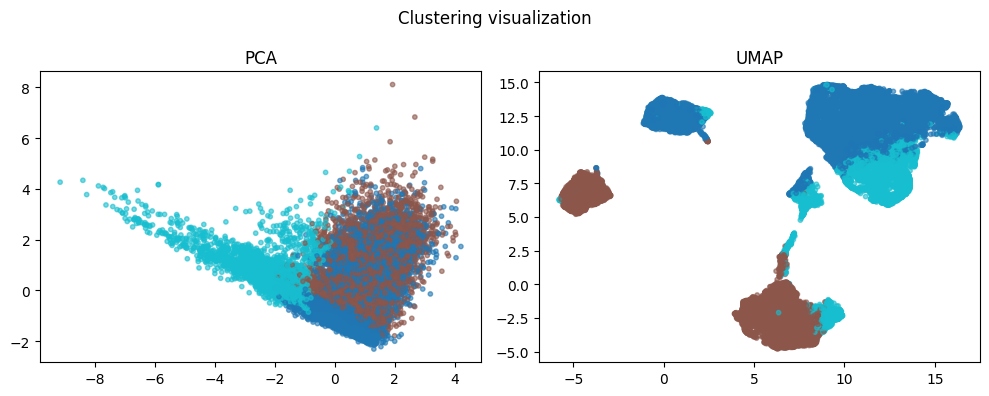

Cluster 0 size: 10094


,Track,Artist
0,Fake ID,Riton
1,Metal Health (Bang Your Head),Quiet Riot
2,Flying High Again,Ozzy Osbourne
3,"Yes Sir, I Can Boogie",Baccara
4,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
5,Keeping Your Head Up,Birdy
6,Shed a Light,Robin Schulz
7,It's All About Me,Mýa
8,Rather Be (feat. Jess Glynne),Clean Bandit
9,Sexy Lady,MC Magic


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'rap', 'pop rap', 'hip hop', 'pop rock', 'classic rock', 'modern rock']
Cluster 1 size: 6480


,Track,Artist
0,Message Man,Twenty One Pilots
1,Crosstown Traffic,Jimi Hendrix
2,All I Want,Alok
3,Look What You Made Me Do,Taylor Swift
4,Secret Door,Arctic Monkeys
5,Monster - Robin Schulz Remix,LUM!X
6,Mr. Saxobeat,Klaas
7,Princesse,Nekfeu
8,React,The Pussycat Dolls
9,Closer,Ne-Yo


Top 10 genres in the cluster: ['pop', 'dance pop', 'rap', 'rock', 'pop rap', 'hip hop', 'post-teen pop', 'modern rock', 'pop dance', 'r&b']
Cluster 2 size: 4243


,Track,Artist
0,Bird Song,Elderbrook
1,Frozen,Madonna
2,As Tears Go By - Mono Version,The Rolling Stones
3,Don't Follow,Alice In Chains
4,Only Love Can Break Your Heart,Neil Young
5,The Load-Out - 2018 Remaster,Jackson Browne
6,(You Make Me Feel Like) A Natural Woman,Aretha Franklin
7,Patience,Guns N' Roses
8,The Last Waltz,Engelbert Humperdinck
9,Tenerife Sea,Ed Sheeran


Top 10 genres in the cluster: ['pop', 'rock', 'classic rock', 'mellow gold', 'adult standards', 'soft rock', 'album rock', 'folk rock', 'post-teen pop', 'dance pop']


In [31]:
kmeans_3 = KMeans(n_clusters=3, n_init="auto", random_state=0)
kmeans_3.fit(X)

kmeans_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
kmeans_analyzer.analyze_clustering(X, kmeans_3)

Patrząc na podział, ewidentnie widać, że niektóre klastry są pomieszane między 2 lub 3 grupy. Widać to też przy okazji `top 10 genres`, gdzie wszędzie wystepuje rock, pop i ich sub-gatunki (i kilka małych dodatków ale nie są one jakoś super outstanding)

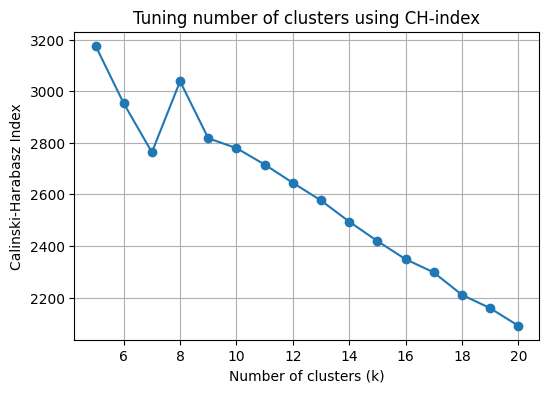

In [32]:
from sklearn.metrics import calinski_harabasz_score

k_range = range(5, 21)
ch_scores = []

for k in k_range:
    model = KMeans(n_clusters=k, n_init="auto", random_state=0)
    model.fit(X)
    ch_score = calinski_harabasz_score(X, model.labels_)
    ch_scores.append(ch_score)

plt.figure(figsize=(6, 4))
plt.plot(k_range, ch_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Calinski-Harabasz Index")
plt.title("Tuning number of clusters using CH-index")
plt.grid(True)
plt.show()

Best k based on CH-index: 5
Number of clusters: 5
CH-index value: 3176.20
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


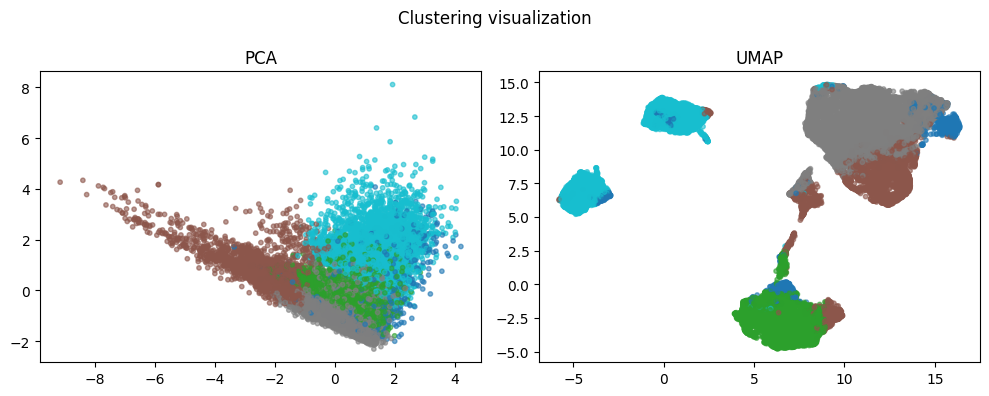

Cluster 0 size: 1130


,Track,Artist
0,Embrasa,Vitão
1,Since I Left You,The Avalanches
2,Shine,Donavon Frankenreiter
3,Bittersweet Symphony (feat. Emily Roberts),GAMPER & DADONI
4,Rescue Me,OneRepublic
5,Can't Get Enough,J. Cole
6,We'll Be Coming Back (feat. Example),Calvin Harris
7,Coming up Easy,Paolo Nutini
8,Tarea Fina,Patricio Rey y sus Redonditos de Ricota
9,Never Let Me Down Again,Depeche Mode


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'rap', 'hip hop', 'pop rap', 'classic rock', 'post-teen pop', 'modern rock', 'album rock']
Cluster 1 size: 4425


,Track,Artist
0,React,The Pussycat Dolls
1,OK,Robin Schulz
2,Foreplay,Jalen Santoy
3,Secret Door,Arctic Monkeys
4,The Sun,Parov Stelar
5,Closer,Ne-Yo
6,Princesse,Nekfeu
7,Going Dumb (with Stray Kids),Alesso
8,Favours,Hayden James
9,Message Man,Twenty One Pilots


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'modern rock', 'edm', 'tropical house', 'classic rock', 'album rock']
Cluster 2 size: 3637


,Track,Artist
0,Bird Song,Elderbrook
1,Frozen,Madonna
2,Don't Follow,Alice In Chains
3,The Load-Out - 2018 Remaster,Jackson Browne
4,Only Love Can Break Your Heart,Neil Young
5,Stay Alive,José González
6,Patience,Guns N' Roses
7,As Tears Go By - Mono Version,The Rolling Stones
8,Slip Slidin' Away,Paul Simon
9,Your Latest Trick,Dire Straits


Top 10 genres in the cluster: ['pop', 'rock', 'adult standards', 'mellow gold', 'classic rock', 'soft rock', 'folk rock', 'post-teen pop', 'album rock', 'dance pop']
Cluster 3 size: 7670


,Track,Artist
0,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
1,Rather Be (feat. Jess Glynne),Clean Bandit
2,Ishq Tera,Guru Randhawa
3,Strangers Like Me,Phil Collins
4,Not Alone,Linkin Park
5,Cheerleader - Felix Jaehn Remix Radio Edit,OMI
6,Defenceless,Louis Tomlinson
7,Penny Lane - Remastered 2015,The Beatles
8,Whine Up (feat. Elephant Man) - English Version,Kat Deluna
9,Keeping Your Head Up,Birdy


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'pop rock', 'classic rock', 'modern rock', 'soft rock', 'mellow gold', 'album rock']
Cluster 4 size: 3955


,Track,Artist
0,Blood On My Jeans,Juice WRLD
1,Augenblick (feat. Summer Cem),KC Rebell
2,Made In Turkey,Murda
3,Broken Clocks,SZA
4,Soleil,Roméo Elvis
5,Surfer,be vis
6,okay,LANY
7,just like magic,Ariana Grande
8,BODY PARTS - I denti,Marracash
9,Worst Behavior,Drake


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'southern hip hop', 'dance pop', 'east coast hip hop', 'melodic rap']


In [33]:
best_k = k_range[np.argmax(ch_scores)]
print(f"Best k based on CH-index: {best_k}")

kmeans_best = KMeans(n_clusters=best_k, n_init="auto", random_state=0)
kmeans_best.fit(X)

best_analyzer = KMeansAnalyzer(df_songs_info, clustering_visualizer)
best_analyzer.analyze_clustering(X, kmeans_best)

Pojawił się rap!

Jest to zdecydowany progress względem (oczywiście) 1 klastra i 3 klastrów, ale wyniki dalej zostawiają dużo do życzenia

Problem z k-means jest taki, że wykrywa tylko klastry sferyczne. W przypadku zbiorów, w których klastry mogą być mocno wymieszane, będzie to szczególnym problemem. Tak może być tutaj - w końcu mamy co najmniej kilka podgatunków rocka i popu, które są zbliżone do siebie. Mamy też dość egzotyczne podgatunki takie jak "art rock" czy "rock en espanol", które być może są nieliczne i stanowią de facto szum.

Do takich sytuacji doskonale nadaje się DBSCAN. Ma co prawda większą złożoność, ale dla danych tego rozmiaru jest to jeszcze akceptowalne. Sprawdźmy, jak działa dla domyślnych hiperparametrów - epsilon 0.5 i min_samples 5.

Number of clusters: 109
Percentage of noise points: 58.13%
CH-index value: 42.50
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


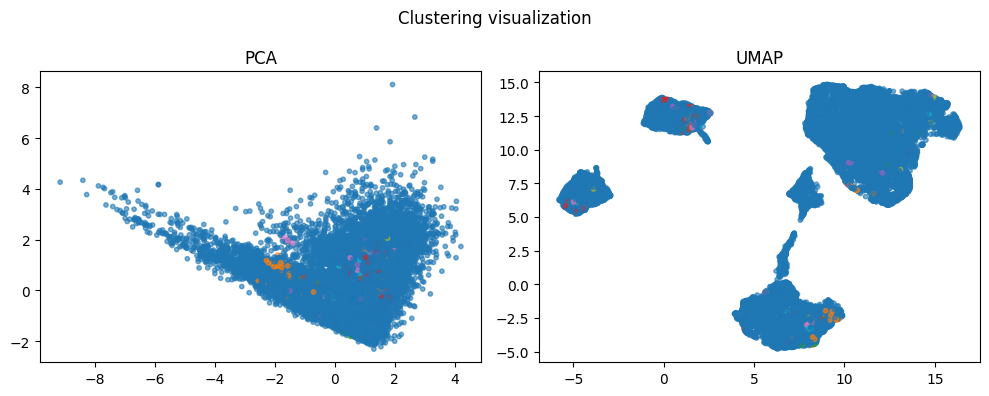

Cluster 0 size: 6151


,Track,Artist
0,Brown Skin,India.Arie
1,Penny Lane - Remastered 2009,The Beatles
2,Black,Dierks Bentley
3,pink skies,LANY
4,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
5,Take Me,RÜFÜS DU SOL
6,Death On Two Legs (Dedicated To...) - Remaster...,Queen
7,I'd Rather,Luther Vandross
8,Apologize,OneRepublic
9,Look Into My Eyes,Brando


Top 10 genres in the cluster: ['pop', 'rock', 'dance pop', 'post-teen pop', 'pop rock', 'modern rock', 'classic rock', 'soft rock', 'mellow gold', 'contemporary country']
Cluster 7 size: 1698


,Track,Artist
0,React,The Pussycat Dolls
1,OK,Robin Schulz
2,Ocean Drive,Duke Dumont
3,Counting Stars,OneRepublic
4,Summer On You (feat. Wulf),Sam Feldt
5,Going Dumb (with Stray Kids),Alesso
6,Drink to That All Night,Jerrod Niemann
7,Foreplay,Jalen Santoy
8,Somewhere With You,Kenny Chesney
9,Come As You Are,Nirvana


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'pop dance', 'edm', 'modern rock', 'tropical house', 'alternative metal', 'pop rock']


In [34]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(n_jobs=-1)
clustering.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Mamy niesamowicie dużo klastrów oraz szumu - niedobrze! Oznacza to, że zbyt ciężko jest "dotrzeć" do kolejnych punktów, żeby stworzyć klastry. Mogą być tego dwie przyczyny:
- zbyt mały promień epsilon
- zbyt duże min_samples

Biorąc pod uwagę, że minimalna liczba próbek to zaledwie 5, to to drugie nie występuje. Musimy zatem zwiększyć promień. Ale jak, skoro nie znamy jednostek?

Dobór hiperparametrów w DBSCAN dobrze opisuje [ten post](http://www.sefidian.com/2022/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/), który zgadza się zresztą z "Data Clustering" Charu C. Aggarwala.

Wartość min_samples można przyjąć z grubsza (rule-of-thumb) jako liczbę wymiarów razy 2. Bierze to poprawkę na rzadkość przestrzeni, i generalnie jest dobrą wartością wyjściową. Jeżeli mamy dużo szumu, to można próbować więcej.

Przy stałym min_samples heurystyka do wyboru epsilon wygląda następująco. Obliczamy rozkład odległości do k najbliższych sąsiadów, przyjmując k = min_samples, a następnie przedstawiamy to na wykresie. Typowo będzie miał kształt z grubsza zbliżony do litery L (lub odwróconego L), i dobra wartość epsilon jest na punkcie przegięcia tego wykresu, tzw. elbow / knee.

**Zadanie 4 (1.5 punktu)**

Stwórz wykres odległości do najbliższych sąsiadów, przyjmując liczbę najbliższych sąsiadów równą 2 razy liczba cech. Może się przydać [ten tutorial](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd).

Odczytaj z wykresu wartość punktu przegięcia. Czy jest to łatwe? Czy jesteś w stanie ją wyznaczyć dokładnie?

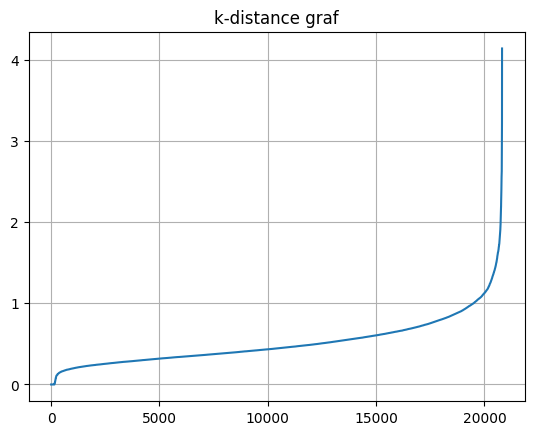

In [35]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

n_features = X.shape[1]
n_neighbors = 2 * n_features

neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("k-distance graf")
plt.grid(True)

Najlepszym punktem dla nas jest dla ~18 tysięcy i jest to między 0.9 a 1.1

Wyznaczenie nie jest perfekcyjne ani łatwe, ale na pewno ułatwia to przyszły tuning

Taka heurystyczna metoda jest wykorzystywana w wielu przypadkach doboru hiperparametrów w klasteryzacji. Zasadnicza idea jest taka, że punkt przegięcia odpowiada momentowi, gdzie dane zaczynają wyraźnie rozróżniać się od siebie i tworzyć wyraźne grupy. Jest to proste i szybkie, ale jest dość nieprecyzyjne w porównaniu do innych metod (jeżeli w ogóle istnieją dla danego zadania!). Jeżeli chcemy zrobić walidację skrośną, korzystając z jakiejś metryki, to taki wykres daje nam sensowny punkt wyjścia do zakresu hiperparametru.

Warto też pamiętać, że klasteryzacja to proces z natury interaktywny. Takie wykresy są ważne, bo zwiększają naszą intuicję, ale np. dokładne dobranie wartości jest typowo robione ręcznie.

**Zadanie 5 (1.5 punktu)**

Wytrenuj DBSCAN z promieniem epsilon wyznaczonym z wykresu i min_samples równym 2 razy liczbie cech. W razie potrzeby zmniejsz lub zwiększ epsilon, aby uzyskać wyniki, które wydają się sensowne (liczba klastrów, procent szumu, CH-index).

Dokonaj analizy wyjściowych klastrów. Czy finalna ich liczba oraz procent szumu są sensowne? Czy klastry są lepiej widoczne, lub lepiej interpretowalne, niż w przypadku k-means?

Number of clusters: 4
Percentage of noise points: 1.14%
CH-index value: 2481.49
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


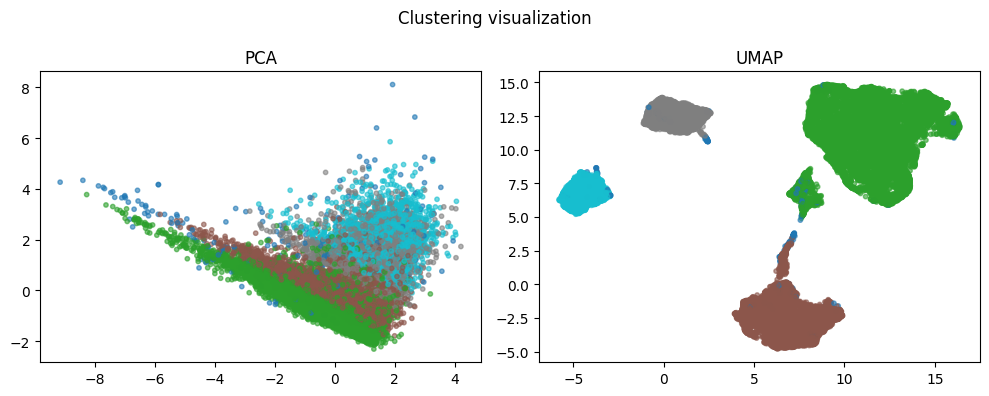

Cluster 0 size: 11142


,Track,Artist
0,Drive (For Daddy Gene),Alan Jackson
1,"Odhani (From ""Made in China"")",Sachin-Jigar
2,You and I,Wilco
3,Penny Lane - Remastered 2009,The Beatles
4,Just A Lover,Hayden James
5,Higher Place - Radio Edit,Dimitri Vegas & Like Mike
6,You'll Be Back,Jonathan Groff
7,Brown Skin,India.Arie
8,Death On Two Legs (Dedicated To...) - Remaster...,Queen
9,Lay It All on Me (feat. Ed Sheeran),Rudimental


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'classic rock', 'post-teen pop', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 1 size: 5306


,Track,Artist
0,The Sun,Parov Stelar
1,Until The End Of Time (with Beyoncé),Justin Timberlake
2,Princesse,Nekfeu
3,Satisfied,Renée Elise Goldsberry
4,Poncho Konos,T3R Elemento
5,Favours,Hayden James
6,Foreplay,Jalen Santoy
7,Greek Tragedy - Oliver Nelson TikTok Remix,The Wombats
8,OK,Robin Schulz
9,React,The Pussycat Dolls


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 2 size: 2243


,Track,Artist
0,Surfer,be vis
1,Worst Behavior,Drake
2,Broken Clocks,SZA
3,BODY PARTS - I denti,Marracash
4,Alien Boy,Oliver Tree
5,Made In Turkey,Murda
6,just like magic,Ariana Grande
7,Professor X,Dave
8,Augenblick (feat. Summer Cem),KC Rebell
9,Blood On My Jeans,Juice WRLD


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 3 size: 1888


,Track,Artist
0,Soleil,Roméo Elvis
1,"A$AP Forever REMIX (feat. Moby, T.I. & Kid Cudi)",A$AP Rocky
2,A$AP Forever (feat. Moby),A$AP Rocky
3,beibs in the trap,Travis Scott
4,1Take (Naija to London),Mixtape Madness
5,Like That (feat. Gucci Mane),Doja Cat
6,"Calipso (with Dardust) (feat. Sfera Ebbasta, M...",Charlie Charles
7,Facetime,Dardan
8,Calumet,Hornet La Frappe
9,Why Do You Lie To Me (feat. Lil Baby),Topic


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']


In [49]:
n_features = X.shape[1]
eps = 1.92
min_samples = 2 * n_features

dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(X)

dbscan_analyzer = DBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, dbscan)

Wyniki zdecydowanie lepsze niż w porównaniu do k-means, ale nie ważne jak dobrać wyniki to te 2 małe clustry łączą się z tymi dużymi 

Dodatkowo też warto zauwazyć że wyniki dla spodziewanego przedziału z poprzedniego zadania były bardzo średnie

DBSCAN ma dwie zasadnicze wady: trudny dobór hiperparametrów oraz podatność na szum. W szczególności to drugie widać, jeżeli w naszym zbiorze ciągle znajduje on dużo szumu - to oznaka, że mamy zmienną gęstość w danych i przydałoby się coś adaptacyjnego, jak OPTICS albo HDBSCAN. OPTICS jest bardziej zoptymalizowany pod pamięć niż szybkość w scikit-learn, plus ma raczej nieintuicyjne hiperparametry (może nawet bardziej, niż DBSCAN), więc wykorzystamy tutaj HDBSCAN.

Jego głównym hiperparametrem jest `min_cluster_size`, czyli po prostu minimalna liczba punktów, aby stworzyć klaster. Dodatkowo `min_samples` ma takie samo znaczenie, jak w DBSCAN, czyli jest to minimalna liczba punktów, aby utworzyć punkt typu CORE. Domyślnie są one równe, ale oczywiście można ustawić `min_samples` (sporo) mniejsze od `min_cluster_size`, i dostrajać oba.

Number of clusters: 11
Percentage of noise points: 6.79%
CH-index value: 817.87
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


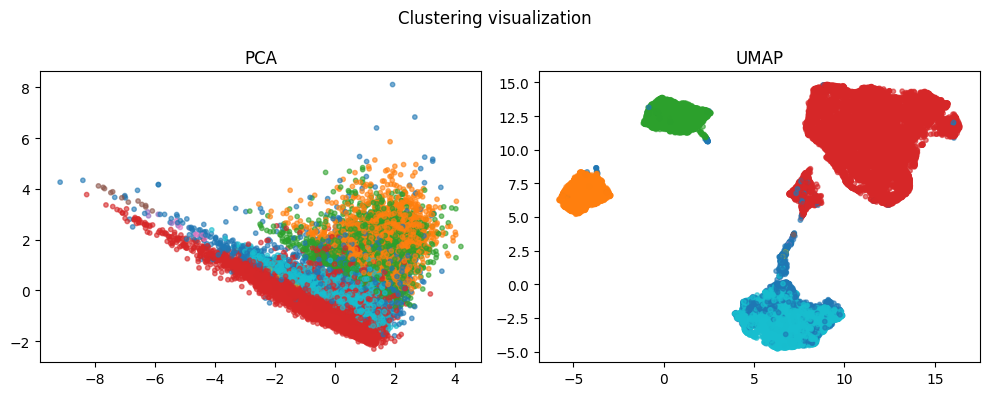

Cluster 3 size: 11154


,Track,Artist
0,Solitude,Billie Holiday
1,"Bewitched, Bothered, And Bewildered",Ella Fitzgerald
2,I'll Look Around,Billie Holiday
3,Love Is Here To Stay - Remastered 1998,Frank Sinatra
4,I Get Along Without You Very Well (Except Some...,Chet Baker
5,It's Always You - Vocal Version,Chet Baker
6,Banana Boat (Day-O),Harry Belafonte
7,You Make Me Feel So Young - Remastered 1998,Frank Sinatra
8,A Day At A Time,Gentle Bones
9,Mack the Knife,Louis Armstrong


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'classic rock', 'post-teen pop', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 9 size: 4035


,Track,Artist
0,Michelle - Remastered 2009,The Beatles
1,I Put A Spell On You,Nina Simone
2,My Generation - Stereo Version,The Who
3,Help! - Remastered 2009,The Beatles
4,Things We Said Today - Remastered 2009,The Beatles
5,I'm Happy Just To Dance With You - Remastered ...,The Beatles
6,I Get Around (Mono),The Beach Boys
7,And I Love Her - Remastered 2009,The Beatles
8,All I've Got To Do - Remastered 2009,The Beatles
9,"Perhaps, Perhaps, Perhaps",Doris Day


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'pop dance', 'edm', 'tropical house', 'classic rock', 'alternative metal']
Cluster 2 size: 2258


,Track,Artist
0,GeForce,PRO8L3M
1,Mordo Wez,Malik Montana
2,Biznes,Sobel
3,dead girl in the pool.,girl in red
4,Killing In the Name,Rage Against The Machine
5,Take The Power Back,Rage Against The Machine
6,Bitches Ain't Shit,Dr. Dre
7,Bombtrack,Rage Against The Machine
8,Killing In The Name,Rage Against The Machine
9,Alwayz Into Somethin',N.W.A.


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 1 size: 1892


,Track,Artist
0,N.Y. State of Mind,Nas
1,Sabotage,Beastie Boys
2,Big Poppa - 2005 Remaster,The Notorious B.I.G.
3,You,Candlebox
4,Wu-Tang Clan Ain't Nuthing ta F' Wit,Wu-Tang Clan
5,You Know How We Do It - Remastered,Ice Cube
6,The Break Up,Machine Gun Kelly
7,Costa Rica,Benjamin Ingrosso
8,LOVERMAN,Mwuana
9,I Wanna Be Somebody,W.A.S.P.


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']


In [50]:
clustering = HDBSCAN()
clustering.fit(X)

dbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
dbscan_analyzer.analyze_clustering(X, clustering)

Domyślne `min_cluster_size` to zaledwie 5, a mimo tego HDBSCAN wcale nie znalazł tak dużo klastrów - pokazuje to jego zdolność do adaptacji do zbioru danych. CH-index nie jest zbyt wysoki, pomimo tego, że niektóre klastry wydają się ciekawe i inne niż w k-means. Pokazuje to też, że klastry pewnie nie są sferyczne.

**Zadanie 6 (2 punkty)**

Dokonaj ręcznego tuningu hiperparametrów `min_cluster_size` oraz `min_samples`. Pamiętaj, że przy stałym `min_samples` możesz praktycznie za darmo zmieniać `min_cluster_size` dzięki cache'owaniu.

Skomentuj finalne wyniki. Czy udało się uzyskać sensowne, interpretowalne klastry? Czy są one w jakimś stopniu nieoczywiste, tj. czy otrzymaliśmy jakąś nową wiedzę dzięki klasteryzacji? Czy CH-index wskazał sensownie na jakość klasteryzacji w HDBSCAN?

Number of clusters: 4
Percentage of noise points: 3.06%
CH-index value: 2536.93
[[-1.62356974  0.21391508]
 [-2.62193386  1.29078671]
 [-3.22540968  0.92172994]
 ...
 [ 0.46427033 -1.31252074]
 [-2.49850574  1.26988221]
 [-0.27308105 -0.69683754]]


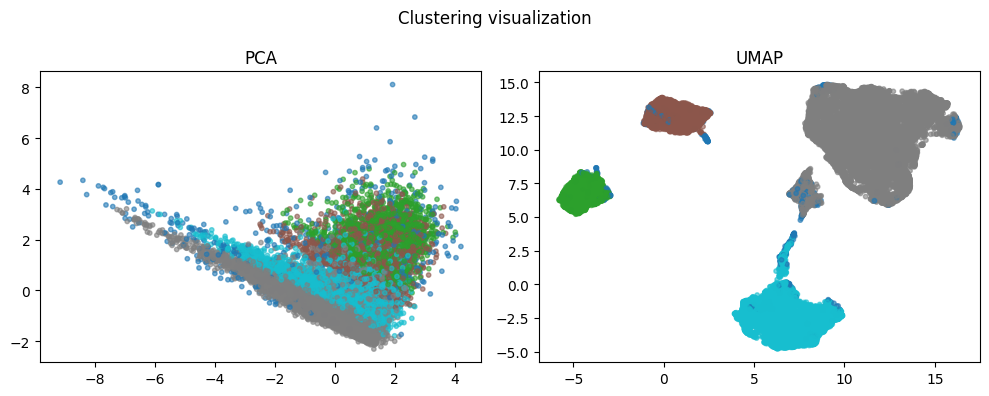

Cluster 2 size: 11015


,Track,Artist
0,Nothing Really Matters,Mr. Probz
1,Four Out Of Five,Arctic Monkeys
2,Chances Are (with Ray Conniff & His Orchestra),Johnny Mathis
3,In The Middle,The Mamas
4,Let It Be,The Mamas
5,Just Imagine It,MKTO
6,You And I,LÉON
7,Walk With Me,Måns Zelmerlöw
8,My Prayer,The Platters
9,7UP,Boy In Space


Top 10 genres in the cluster: ['rock', 'pop', 'dance pop', 'post-teen pop', 'classic rock', 'mellow gold', 'soft rock', 'pop rock', 'album rock', 'modern rock']
Cluster 3 size: 5184


,Track,Artist
0,Kick It,BLACKPINK
1,WHISTLE - Japanese Version,BLACKPINK
2,Cemetery Drive,My Chemical Romance
3,Kill Em With Kindness,Selena Gomez
4,The Riddle Anthem Rework,Mike Candys
5,Hey Brother,Avicii
6,Counting Stars,OneRepublic
7,BURN IT DOWN,Linkin Park
8,Diamonds,Rihanna
9,Wait Another Day,Mike Williams


Top 10 genres in the cluster: ['pop', 'dance pop', 'rock', 'post-teen pop', 'modern rock', 'classic rock', 'pop dance', 'edm', 'tropical house', 'album rock']
Cluster 1 size: 2164


,Track,Artist
0,I Don't Like,Chief Keef
1,The Question,Mac Miller
2,EVERE$T,Ati242
3,Scream & Shout,will.i.am
4,Some Nights,fun.
5,"New Chains, Same Shackles",$uicideboy$
6,5 shots,gianni & kyle
7,Freak,Doja Cat
8,Hyperfine,G Flip
9,Cryin' Like A Bitch!!,Godsmack


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'pop', 'trap', 'gangster rap', 'southern hip hop', 'dance pop', 'post-teen pop', 'east coast hip hop']
Cluster 0 size: 1817


,Track,Artist
0,Sham Pain,Five Finger Death Punch
1,Ballin,Luciano
2,Nothin' But The Cavi Hit,Mack 10
3,Ayo Technology,Kynda Gray
4,CASINO ROYAL,Kianush
5,Summer Days (feat. Macklemore & Patrick Stump ...,Martin Garrix
6,Incomplete,Sisqo
7,Macarena (feat. Offset),Sfera Ebbasta
8,Fiji,Taco Hemingway
9,The Break Up,Machine Gun Kelly


Top 10 genres in the cluster: ['rap', 'hip hop', 'pop rap', 'trap', 'pop', 'gangster rap', 'dance pop', 'southern hip hop', 'east coast hip hop', 'r&b']


In [64]:
min_cluster_size = 65
min_samples = 20

hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
hdbscan.fit(X)

hdbscan_analyzer = HDBSCANAnalyzer(df_songs_info, clustering_visualizer)
hdbscan_analyzer.analyze_clustering(X, hdbscan)

Przy testowaniu wielu różnych wartości najlepsze wyniki miały szum około 4% (bardzo dobry wynik) i ilośc klastrów w okolicach 4-5. HDBSCAN umożliwił też zauważenie mi interpretowalności w danych na PCA.

## Zadanie dodatkowe (3 punkty)

Klasteryzacja hierarchiczna jest przydatnym narzędziem, dającym od razu znaczną ilość informacji co do klasteryzacji, ale ze względu na złożoność nadaje się tylko do mniejszych zbiorów danych. Takim zbiorem jest dobrze nam już znany [Ames housing](https://www.openintro.org/book/statdata/?data=ames).

1. Załaduj zbiór i dokonaj odpowiedniego preprocessingu. Zwizualizuj go z pomocą PCA oraz UMAP.
2. Zastosuj klasteryzację hierarchiczną do tego zbioru, wykorzystując metrykę euklidesową i Ward linkage.
3. Narysuj dendrogram dla wynikowej klasteryzacji. Czy widać jakąś strukturę klastrującą? Sprawdź kilka przykładowych próbek, które wydają się podobne - czy faktycznie te domy są podobne?
4. Wybierz klasteryzację, która wydaje się najbardziej stabilna, tj. ma najdłuższe pionowe linie na dendrogramie. Sprawdź jej CH-index, oraz zwizualizuj ją za pomocą PCA oraz UMAP. Ile ma ona klastrów? Czy wydaje się ona sensowna? Wypisz przykładowe domy z klastrów. Czy faktycznie wskazują na zróżnicowanie klastrów?
5. Porównaj tę klasteryzację z k-means (dokonaj tuningu liczby klastrów z pomocą CH-index) oraz HDBSCAN. Ile klastrów wybrały te metody? Czy na wizualizacji PCA i UMAP dają lepsze, czy gorsze wyniki od klasteryzacji hierarchicznej?